In [223]:
import utils
import numpy as np
from skimage import io
from sklearn.cluster import KMeans 
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("image", cmap="gray")

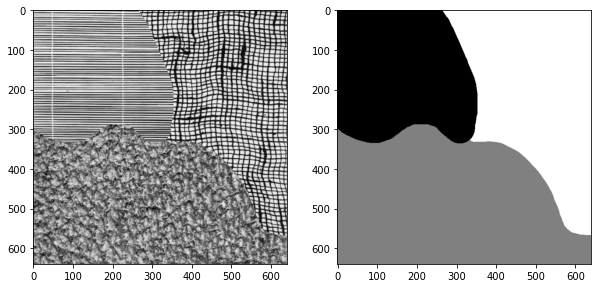

In [185]:
train_x_filename = "../../data/week3/3labels/training_image.png"
train_x = io.imread(train_x_filename)
train_x = train_x.astype(float)

train_Y_filename = "../../data/week3/3labels/training_labels.png"
train_Y = io.imread(train_Y_filename)
train_Y = train_Y.astype(float)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(train_x)
ax2.imshow(train_Y)

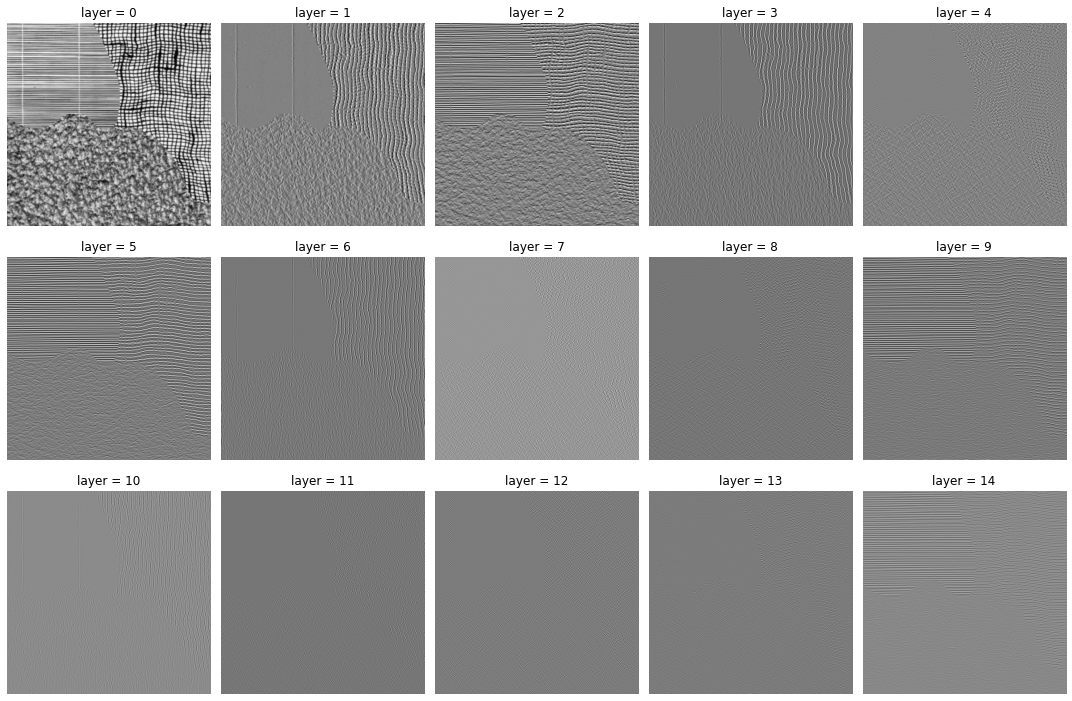

In [186]:
sigma = 1
gf = utils.get_gauss_feat_im(train_x, sigma)
fig, axs = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=True)
for layer, ax in enumerate(axs.flatten()):
    ax.imshow(gf[:, :, layer])
    ax.axis(False)
    ax.set_title(f"{layer = }")
    
plt.tight_layout()

## r x c x 15n -> rc x 15n

In [187]:
def reshape_to_rcxn(gf: np.array) -> np.array:
    return gf.reshape((-1, gf.shape[-1]))

train_x_rcn = reshape_to_rcxn(gf)

## Label prob image
### Rly just onehot encodeded labels

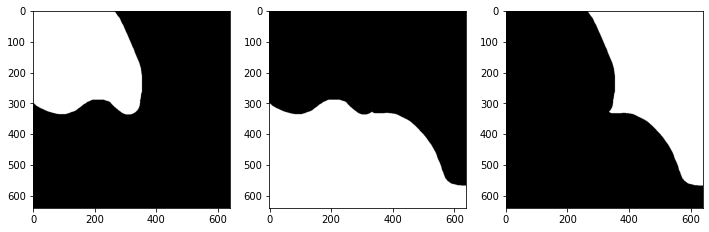

In [188]:
def onehot_encode_labels(lab_img: np.array) -> np.array:
    pxl_vals = np.unique(lab_img)
    z = pxl_vals.size
    img = np.zeros((*lab_img.shape, z))
    for i, pxl_val in enumerate(pxl_vals):
        img[lab_img == pxl_val, i] = 1
    return img
    
train_Y_prob = onehot_encode_labels(train_Y)
fig, axs = plt.subplots(1, train_Y_prob.shape[-1], figsize=(4*train_Y_prob.shape[-1], 4))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(train_Y_prob[:, :, i])

train_Y_rcn = reshape_to_rcxn(train_Y_prob)

In [225]:
def build_dict(train_x: np.array, train_Y: np.array, cluster_num: int = 1000, subset_size=5000) -> (np.array, KMeans):
    assert train_x.shape[0] == train_Y.shape[0]
    
    idx = np.random.choice(train_x.shape[0], size=subset_size)
    subset_x = train_x[idx]
    subset_Y = train_Y[idx]

    cluster = KMeans(n_clusters=cluster_num)
    cluster_centers = cluster.fit_predict(subset_x)

    cluster_props = np.zeros((subset_Y.shape[-1], cluster_num))
    arr_idx = np.where(subset_Y[:] == 1)[1], cluster_centers
    np.add.at(cluster_props, arr_idx, 1)

    cluster_props /= cluster_props.sum(axis=0)
    return cluster_props, cluster

cluster_num = 1000
probs, cluster = build_dict(train_x_rcn, train_Y_rcn, cluster_num=cluster_num, subset_size=10000)

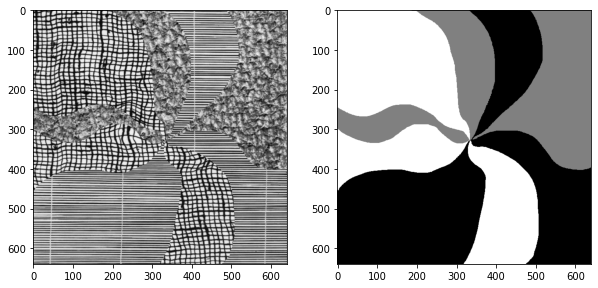

In [217]:
train_x_filename = "../../data/week3/3labels/testing_image.png"
test_x = io.imread(train_x_filename)
test_x = test_x.astype(float)

train_Y_filename = "../../data/week3/3labels/testing_labels.png"
test_Y = io.imread(train_Y_filename)
test_Y = test_Y.astype(float)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_x)
ax2.imshow(test_Y)

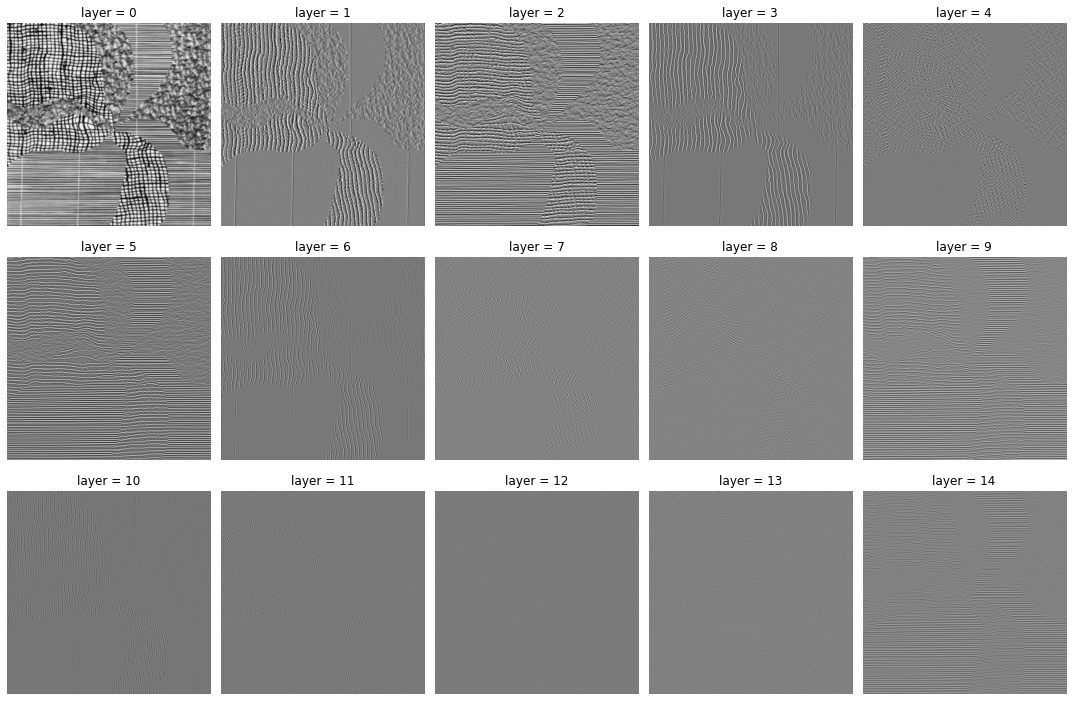

In [218]:
sigma = 1
gf = utils.get_gauss_feat_im(test_x, sigma)
fig, axs = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=True)
for layer, ax in enumerate(axs.flatten()):
    ax.imshow(gf[:, :, layer])
    ax.axis(False)
    ax.set_title(f"{layer = }")
    
plt.tight_layout()

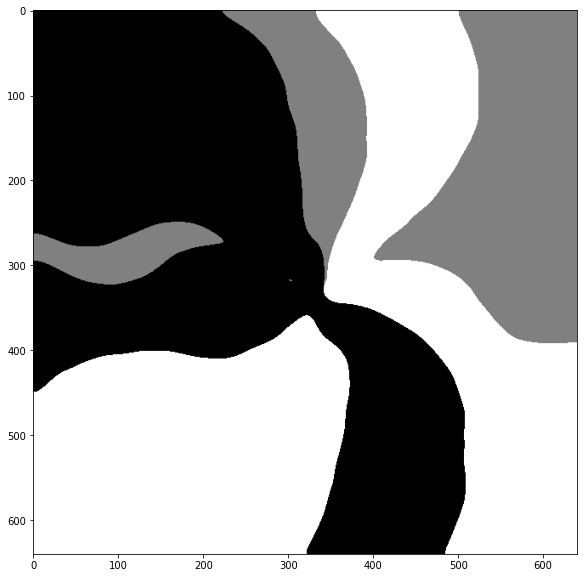

In [252]:
test_x_rcn = reshape_to_rcxn(gf)
predictions = cluster.predict(test_x_rcn)
pixel_props = probs[:, predictions]
prop_smooth = gaussian_filter(
    pixel_props.reshape((3, 640, 640)).transpose((1, 2, 0)),
    sigma=10)\
    .transpose((2, 0, 1))\
    .reshape((3, -1))
pixel_val = prop_smooth.argmax(axis=0)
pixel_img = pixel_val.reshape(640, 640)
plt.figure(figsize=(10, 10))
plt.imshow(pixel_img)

In [260]:
arr = np.zeros((256, 408))
res = utils.im2col(arr, patch_size=[9, 9])
np.prod(res.shape)

8035200

In [275]:
a = np.array([
    [0.11, 0.16, 0.21, 0.26, 0.31],
    [.09, .14, .19, .14, .29],
    [.07, .12, .17, .22, .27]
])

b = np.array([
    [.67, .55, .43, .31, .19],
    [.59, .47, .35, .23, .11],
    [.51, .39, .27, .15, .03]
])

c = np.ones_like(a) - (a + b)

al = np.array([a, b, c])
al.argmax(axis=0)

array([[1, 1, 1, 2, 2],
       [1, 1, 2, 2, 2],
       [1, 2, 2, 2, 2]])